In [20]:
import numpy as np 
import pandas as pd
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset
from torchvision import models
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import time
from tqdm import tqdm

In [2]:
# ======================= PYTHON SETTINGS ======================= #
# =======================   GPU or CPU    ======================= #

device = torch.device("cpu")

# Check if GPU is available -> CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))

# Apple Silicon GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    out = torch.ones(1, device=device)
    print (out)
    print ("MPS device found. - Apple Silicon GPU")
else:
    print ("MPS device not found.")


print("Device:", device)

# =======================   Ranom Seeds   ======================= #
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# =============================================================== #

tensor([1.], device='mps:0')
MPS device found. - Apple Silicon GPU
Device: mps


In [3]:
# ======================= NORMALIZE PARAMS ======================= #
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(           # Normalize the images
        # average values of the red, green, 
        # and blue channels across all images in the ImageNet dataset.
        mean=[0.485, 0.456, 0.406], 
        # standard deviation of the red, green, and blue 
        # channels across all images in the ImageNet dataset.
        std=[0.229, 0.224, 0.225]   
    )
])

# ======================= DATA AUGMENTATION ======================= #
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),            # Resize images to a consistent size
    transforms.RandomHorizontalFlip(),        # Random horizontal flipping
    transforms.RandomRotation(15),            # Random rotation by 10 degrees
    transforms.ColorJitter(brightness=0.2,    # Adjust brightness, contrast, saturation, and hue
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(                     # Normalize the images
        mean=[0.485, 0.456, 0.406],           # Mean for ImageNet dataset
        std=[0.229, 0.224, 0.225]             # Standard deviation for ImageNet dataset
    )
])

In [4]:
# ======================= LOAD MAIN DATASET ======================= #
# Download and load the Food101 dataset
train_dataset = torchvision.datasets.Food101(
    root='./data',                 # Directory to save the downloaded data
    split='train',
    download=True,                 # Download the data if not present
    transform=train_transform            # Apply the train_transform to the data
)

test_dataset = torchvision.datasets.Food101(
    root='./data',                 # Directory to save the downloaded data
    split='test',
    download=True,                 # Download the data if not present
    transform=transform            # Apply the transform to the data
)

In [8]:
# def get_labels_from_loader(loader):
#     labels = []
#     for _, label in loader:
#         labels.extend(label.tolist())
#     return labels

# def get_subset_with_n_classes(original_dataset, n_classes, batch_size=64):
#     # Check if the dataset is a Subset
#     if isinstance(original_dataset, Subset):
#         # Create a DataLoader to extract labels from the Subset
#         subset_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
#         # Extract labels
#         targets = get_labels_from_loader(subset_loader)
#     else:
#         # Try to access labels through the targets attribute
#         try:
#             targets = original_dataset.targets
#         except AttributeError:
#             # If targets attribute doesn't exist, use __getitem__ method
#             targets = [original_dataset[i][1] for i in range(len(original_dataset))]

#     # Find the unique classes and select the first n
#     unique_classes = torch.unique(torch.tensor(targets))
#     selected_classes = unique_classes[:n_classes].tolist()

#     # Get the indices of samples belonging to the selected classes
#     selected_indices = [i for i, t in enumerate(targets) if t in selected_classes]

#     # Handle if the dataset is already a Subset
#     if isinstance(original_dataset, Subset):
#         # Adjust indices to map to the original dataset
#         original_indices = [original_dataset.indices[i] for i in selected_indices]
#         # Create a new Subset from the original dataset
#         subset = Subset(original_dataset.dataset, original_indices)
#     else:
#         # Create a new Subset
#         subset = Subset(original_dataset, selected_indices)

#     return subset

def get_labels_from_loader(loader):
    # Concatenate all labels into a single NumPy array for efficiency
    return np.concatenate([labels.numpy() for _, labels in loader])

def get_subset_with_n_classes(original_dataset, n_classes, batch_size=64):
    # Check if the dataset is a Subset
    if isinstance(original_dataset, Subset):
        # Create a DataLoader with a larger batch size for efficiency
        subset_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
        targets = get_labels_from_loader(subset_loader)
    else:
        # Try to access labels through the targets attribute
        try:
            targets = np.array(original_dataset.targets)
        except AttributeError:
            # Use list comprehension and NumPy for efficient label extraction
            targets = np.array([original_dataset[i][1] for i in range(len(original_dataset))])

    # Find the unique classes and select the first n
    unique_classes = np.unique(targets)
    selected_classes = unique_classes[:n_classes]

    # Vectorized operation for selecting indices
    selected_indices = np.where(np.isin(targets, selected_classes))[0]

    # Handle if the dataset is already a Subset
    if isinstance(original_dataset, Subset):
        original_indices = original_dataset.indices[selected_indices]
        subset = Subset(original_dataset.dataset, original_indices)
    else:
        subset = Subset(original_dataset, selected_indices)

    return subset



# Get a subset with the first n classes
n = 5  # For example, get the first 5 classes
subset_train = get_subset_with_n_classes(train_dataset, n)
subset_test = get_subset_with_n_classes(test_dataset, n)

In [10]:
# test for small sets

print("subset_test", subset_train[0][0])
print("subset_test", subset_train[0][1])



subset_test tensor([[[ 2.1119,  2.0948,  2.1119,  ..., -0.5424, -0.6281, -0.5424],
         [ 2.1290,  2.1119,  2.1290,  ..., -0.4226, -0.4739, -0.4568],
         [ 2.1462,  2.1290,  2.1462,  ..., -0.3883, -0.4054, -0.4397],
         ...,
         [ 0.5022,  0.4679,  0.4508,  ...,  0.3309,  0.3138,  0.3481],
         [ 0.4851,  0.4508,  0.3994,  ...,  0.4337,  0.3994,  0.4679],
         [ 0.4166,  0.3652,  0.3481,  ...,  0.5022,  0.4679,  0.4851]],

        [[ 2.2185,  2.2010,  2.2185,  ..., -1.4405, -1.5455, -1.4755],
         [ 2.2360,  2.2185,  2.2360,  ..., -1.3179, -1.3880, -1.4230],
         [ 2.2535,  2.2360,  2.2535,  ..., -1.3004, -1.3704, -1.4230],
         ...,
         [-0.6877, -0.7227, -0.7577,  ...,  0.2402,  0.2927,  0.3452],
         [-0.7052, -0.7402, -0.7927,  ...,  0.3627,  0.3803,  0.4853],
         [-0.7752, -0.8277, -0.8452,  ...,  0.4328,  0.4503,  0.5028]],

        [[ 2.4483,  2.4308,  2.4483,  ..., -1.5081, -1.6476, -1.6127],
         [ 2.4657,  2.4483,  2.46

In [11]:
# =======================     DATA INFO    ======================= #
print('Train dataset length:',      len(train_dataset))
print('Test dataset length:',       len(test_dataset))
print('Classes:',                   train_dataset.classes)
print('Number of classes:',         len(train_dataset.classes))
print("===============================================")
print('Sample image shape:',        np.shape(train_dataset[0][0]))
# print('Sample image shape [0][0]:', train_dataset[0][0])
print('Sample image label [0][1]:', train_dataset[0][1])
print('Sample image class:',        train_dataset.classes[train_dataset[0][1]])

Train dataset length: 75750
Test dataset length: 25250
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobs

In [ ]:
# def display_image(dataset, index):
#     plt.imshow(dataset[index][0])                       # Plot the image
#     plt.title(train_dataset.classes[dataset[index][1]]) # Set the title 
# ======================== DISPLAY IMAGE (FROM MAIN DATASET) ======================== #
def display_image(dataset, index):
    image, label = dataset[index]
    image = to_pil_image(image)
    plt.imshow(image)
    plt.title(train_dataset.classes[label])

display_image(train_dataset, 33)

In [ ]:
# SHOW AN IMAGE FROM THE SUBSET

def display_image(dataset, index):
    image, label = dataset[index]
    image = to_pil_image(image)
    plt.imshow(image)
    plt.title(train_dataset.classes[label])

display_image(subset_train, 2620)


In [ ]:
# ================ SAMPLE IMAGE FOR ALL CLASSES ================ #
def display_each_class(dataset):
    plt.figure(figsize=(256, 256))  # Adjust the figure size as needed
    for idx in range(0, len(train_dataset.classes)):
        plt.subplot(26, 4, idx+1)
        plt.imshow(dataset[idx * 750][0])  # Indexing starts from 0
        plt.title(dataset.classes[dataset[idx * 750][1]])
        # plt.xticks([])
        # plt.yticks([])

    plt.tight_layout()  # Move this outside the loop
    # plt.show()
    plt.savefig("output.png")

display_each_class(train_dataset)

In [ ]:
# General function to display the histogram of the images
def list_image_paths(root_dir = "data/food-101/images", extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []

    for root, dirs, files in os.walk(root_dir):
        #write in red
        # print('\033[91m' + root)
        for file in files:
            #write in blue
            # print('\033[94m' + file)
    
            if any(file.lower().endswith(ext) for ext in extensions):
                image_paths.append(os.path.join(root, file))
                break
            

    return image_paths

def display_histogram(image_paths):
    # Load images and extract pixel values
    images = [np.array(Image.open(image_path).convert("RGB")) for image_path in image_paths]
    
    # Flatten the 3D array of pixel values into a 1D array
    pixel_values_flat = np.concatenate([image.flatten() for image in images])

    # print('Total number of pixels:', len(pixel_values_flat))

    # Make a histogram for the pixel values
    plt.figure(figsize=(20, 10))
    plt.hist(pixel_values_flat, bins=20, range=(0, 255), color='blue', edgecolor='black')
    plt.title('Distribution of Pixel Intensities in the Dataset')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

test = list_image_paths()
# print(len(test))
# print(test[0:101])
display_histogram(test)

In [25]:
# =======================   CNN MODEL    ======================= #
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# =======================   CNN MODEL    ======================= #
class SimpleCNN2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN2, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 128 * 128, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 128 * 128)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [14]:
class SimpleCNN3(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.2):
        super(SimpleCNN3, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after the first convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after the second convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm after the third convolutional layer
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 128 * 128, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # BatchNorm after the first fully connected layer
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout before the first fully connected layer
        self.fc2 = nn.Linear(1024, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)  # BatchNorm after the second fully connected layer
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout before the second fully connected layer
        self.fc3 = nn.Linear(1024, 1024)
        self.bn_fc3 = nn.BatchNorm1d(1024)  # BatchNorm after the third fully connected layer
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout before the third fully connected layer
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply BatchNorm after the first convolutional layer
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply BatchNorm after the second convolutional layer
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply BatchNorm after the third convolutional layer
        x = x.view(-1, 128 * 128 * 128)  # Flatten the tensor
        x = F.relu(self.bn_fc1(self.fc1(x)))  # Apply BatchNorm after the first fully connected layer
        x = self.dropout1(x)  # Apply dropout before the first fully connected layer
        x = F.relu(self.bn_fc2(self.fc2(x)))  # Apply BatchNorm after the second fully connected layer
        x = self.dropout2(x)  # Apply dropout before the second fully connected layer
        x = F.relu(self.bn_fc3(self.fc3(x)))  # Apply BatchNorm after the third fully connected layer
        x = self.dropout3(x)  # Apply dropout before the third fully connected layer
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [10]:
class CustomImageClassifier(nn.Module):
   def __init__(self, num_classes):
       super(CustomImageClassifier, self).__init__()
      
       # Load a pre-trained model (e.g., ResNet)
       self.model = models.resnet18(pretrained=True)
      
       # Freeze the parameters of the model
       for param in self.model.parameters():
           param.requires_grad = False


       # Assuming ResNet18 is used, the in_features for the first added linear layer
       in_features = self.model.fc.in_features


       # Replace the fully connected layer
       self.model.fc = nn.Sequential(
           nn.Linear(in_features, 512),
           nn.ReLU(),
           nn.BatchNorm1d(512),
           nn.Dropout(0.5),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.BatchNorm1d(256),
           nn.Dropout(0.5),
           nn.Linear(256, num_classes)
       )


   def forward(self, x):
       return self.model(x)

In [ ]:
class CustomImageClassifier5(nn.Module):
   def __init__(self, num_classes):
       super(CustomImageClassifier, self).__init__()
      
       # Load a pre-trained model (e.g., ResNet)
       self.model = models.resnet50(pretrained=True)
      
       # Freeze the parameters of the model
       for param in self.model.parameters():
           param.requires_grad = False


       # Assuming ResNet18 is used, the in_features for the first added linear layer
       in_features = self.model.fc.in_features


       # Replace the fully connected layer
       self.model.fc = nn.Sequential(
           nn.Linear(in_features, 512),
           nn.ReLU(),
           nn.BatchNorm1d(512),
           nn.Dropout(0.5),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.BatchNorm1d(256),
           nn.Dropout(0.5),
           nn.Linear(256, num_classes)
       )


   def forward(self, x):
       return self.model(x)

In [ ]:
# ======================= SMALL MODEL TRAINING FOR 5 CLASSES ======================= #
# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 5 # ? temporary 5
learning_rate = 0.001
num_folds = 5  # Number of folds for K-fold cross-validation

# Initialize KFold for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_model = None
best_val_accuracy = 0.0

for fold, (train_indices, val_indices) in enumerate(kf.split(subset_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Initialize model, loss function, and optimizer
    model = CustomImageClassifier(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Split the data into training and validation sets for this fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, sampler=val_sampler)

    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        # Training loop
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch"):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        val_accuracy = total_correct / total_samples
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.4f}")

        # Check if this model has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

# After K-fold cross-validation, use the best model for testing
model.load_state_dict(best_model)
model.eval()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

# Define the data loader for testing
test_loader = torch.utils.data.DataLoader(subset_test, batch_size=batch_size, shuffle=False)

# Testing loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

In [18]:
# ======================= BIG MODEL TRAINING FOR 101 CLASSES ======================= #

torch.backends.cudnn.enabled = False

print("Device:", device)
if device == torch.device("cpu"):
    print("Training on CPU - not recommended!")
    print("ABORTING")
    exit()

# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 101
learning_rate = 0.001
num_folds = 5
seed = 42

# Initialize KFold for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_model = None
best_val_accuracy = 0.0

for fold, (train_indices, val_indices) in enumerate(kf.split(subset_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Initialize model, loss function, and optimizer
    model = CustomImageClassifier(num_classes).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Split the data into training and validation sets for this fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(subset_train, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=8)
    val_loader = DataLoader(subset_train, batch_size=batch_size, sampler=val_sampler, pin_memory=True, num_workers=8)

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast("mps"):
                outputs = model(images.to(device))
                loss = criterion(outputs, labels.to(device))

            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.cuda.amp.autocast("mps"):
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        val_accuracy = total_correct / total_samples

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.4f}")

        # Check if this model has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

# After K-fold cross-validation, use the best model for testing
model.load_state_dict(best_model)
model.eval()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

# Define the data loader for testing
test_loader = DataLoader(subset_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Testing loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels.to(device)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/efe/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/efe/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: mps
Fold 1/5


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]/Users/efe/miniconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training:   5%|▌         | 1/20 [02:45<52:25, 165.54s/epoch]

Epoch [1/20] - Validation Accuracy: 0.4523


Training:  10%|█         | 2/20 [05:30<49:38, 165.49s/epoch]

Epoch [2/20] - Validation Accuracy: 0.4782


Training:  15%|█▌        | 3/20 [08:14<46:41, 164.78s/epoch]

Epoch [3/20] - Validation Accuracy: 0.4855


Training:  20%|██        | 4/20 [10:58<43:51, 164.48s/epoch]

Epoch [4/20] - Validation Accuracy: 0.4887


Training:  25%|██▌       | 5/20 [13:42<41:04, 164.31s/epoch]

Epoch [5/20] - Validation Accuracy: 0.4939


Training:  30%|███       | 6/20 [16:26<38:15, 163.95s/epoch]

Epoch [6/20] - Validation Accuracy: 0.4981


Training:  35%|███▌      | 7/20 [19:10<35:32, 164.07s/epoch]

Epoch [7/20] - Validation Accuracy: 0.4992


Training:  40%|████      | 8/20 [21:53<32:45, 163.81s/epoch]

Epoch [8/20] - Validation Accuracy: 0.5062


Training:  45%|████▌     | 9/20 [24:37<30:03, 163.92s/epoch]

Epoch [9/20] - Validation Accuracy: 0.5099


Training:  50%|█████     | 10/20 [27:23<27:24, 164.48s/epoch]

Epoch [10/20] - Validation Accuracy: 0.5082


Training:  55%|█████▌    | 11/20 [30:07<24:38, 164.28s/epoch]

Epoch [11/20] - Validation Accuracy: 0.5102


Training:  60%|██████    | 12/20 [32:48<21:45, 163.22s/epoch]

Epoch [12/20] - Validation Accuracy: 0.5101


Training:  65%|██████▌   | 13/20 [35:30<19:00, 162.92s/epoch]

Epoch [13/20] - Validation Accuracy: 0.5139


Training:  70%|███████   | 14/20 [38:13<16:17, 163.00s/epoch]

Epoch [14/20] - Validation Accuracy: 0.5183


Training:  75%|███████▌  | 15/20 [40:55<13:33, 162.67s/epoch]

Epoch [15/20] - Validation Accuracy: 0.5156


Training:  80%|████████  | 16/20 [43:38<10:50, 162.74s/epoch]

Epoch [16/20] - Validation Accuracy: 0.5182


Training:  85%|████████▌ | 17/20 [46:32<08:18, 166.10s/epoch]

Epoch [17/20] - Validation Accuracy: 0.5181


Training:  90%|█████████ | 18/20 [49:43<05:47, 173.61s/epoch]

Epoch [18/20] - Validation Accuracy: 0.5181


Training:  95%|█████████▌| 19/20 [52:33<02:52, 172.54s/epoch]

Epoch [19/20] - Validation Accuracy: 0.5171


Training: 100%|██████████| 20/20 [55:20<00:00, 166.02s/epoch]

Epoch [20/20] - Validation Accuracy: 0.5205
Fold 2/5



Training:   5%|▌         | 1/20 [02:46<52:47, 166.73s/epoch]

Epoch [1/20] - Validation Accuracy: 0.4543


Training:  10%|█         | 2/20 [05:33<49:57, 166.56s/epoch]

Epoch [2/20] - Validation Accuracy: 0.4744


Training:  15%|█▌        | 3/20 [08:20<47:18, 166.95s/epoch]

Epoch [3/20] - Validation Accuracy: 0.4921


Training:  20%|██        | 4/20 [11:06<44:24, 166.53s/epoch]

Epoch [4/20] - Validation Accuracy: 0.4937


Training:  25%|██▌       | 5/20 [13:51<41:32, 166.15s/epoch]

Epoch [5/20] - Validation Accuracy: 0.5042


Training:  30%|███       | 6/20 [16:37<38:43, 165.99s/epoch]

Epoch [6/20] - Validation Accuracy: 0.5054


Training:  35%|███▌      | 7/20 [19:21<35:47, 165.22s/epoch]

Epoch [7/20] - Validation Accuracy: 0.5105


Training:  40%|████      | 8/20 [22:04<32:54, 164.51s/epoch]

Epoch [8/20] - Validation Accuracy: 0.5089


Training:  45%|████▌     | 9/20 [24:47<30:06, 164.27s/epoch]

Epoch [9/20] - Validation Accuracy: 0.5061


Training:  50%|█████     | 10/20 [27:34<27:28, 164.90s/epoch]

Epoch [10/20] - Validation Accuracy: 0.5140


Training:  55%|█████▌    | 11/20 [30:19<24:45, 165.05s/epoch]

Epoch [11/20] - Validation Accuracy: 0.5176


Training:  60%|██████    | 12/20 [33:04<22:00, 165.06s/epoch]

Epoch [12/20] - Validation Accuracy: 0.5196


Training:  65%|██████▌   | 13/20 [35:49<19:13, 164.85s/epoch]

Epoch [13/20] - Validation Accuracy: 0.5176


Training:  70%|███████   | 14/20 [40:30<19:59, 199.96s/epoch]

Epoch [14/20] - Validation Accuracy: 0.5190


Training:  75%|███████▌  | 15/20 [43:36<16:18, 195.78s/epoch]

Epoch [15/20] - Validation Accuracy: 0.5222


Training:  80%|████████  | 16/20 [47:08<13:22, 200.73s/epoch]

Epoch [16/20] - Validation Accuracy: 0.5245


Training:  85%|████████▌ | 17/20 [50:04<09:40, 193.40s/epoch]

Epoch [17/20] - Validation Accuracy: 0.5221


Training:  90%|█████████ | 18/20 [52:59<06:15, 187.66s/epoch]

Epoch [18/20] - Validation Accuracy: 0.5251


Training:  95%|█████████▌| 19/20 [55:51<03:03, 183.08s/epoch]

Epoch [19/20] - Validation Accuracy: 0.5220


Training: 100%|██████████| 20/20 [58:44<00:00, 176.23s/epoch]

Epoch [20/20] - Validation Accuracy: 0.5256
Fold 3/5



Training:   5%|▌         | 1/20 [02:52<54:37, 172.48s/epoch]

Epoch [1/20] - Validation Accuracy: 0.4538


Training:  10%|█         | 2/20 [05:47<52:10, 173.90s/epoch]

Epoch [2/20] - Validation Accuracy: 0.4715


Training:  15%|█▌        | 3/20 [08:42<49:23, 174.30s/epoch]

Epoch [3/20] - Validation Accuracy: 0.4817


Training:  20%|██        | 4/20 [11:34<46:15, 173.45s/epoch]

Epoch [4/20] - Validation Accuracy: 0.4903


Training:  25%|██▌       | 5/20 [14:26<43:15, 173.01s/epoch]

Epoch [5/20] - Validation Accuracy: 0.4933


Training:  30%|███       | 6/20 [17:16<40:09, 172.12s/epoch]

Epoch [6/20] - Validation Accuracy: 0.4978


Training:  35%|███▌      | 7/20 [20:08<37:16, 172.00s/epoch]

Epoch [7/20] - Validation Accuracy: 0.5022


Training:  40%|████      | 8/20 [22:59<34:21, 171.78s/epoch]

Epoch [8/20] - Validation Accuracy: 0.5042


Training:  45%|████▌     | 9/20 [25:53<31:36, 172.42s/epoch]

Epoch [9/20] - Validation Accuracy: 0.5057


Training:  50%|█████     | 10/20 [28:40<28:26, 170.70s/epoch]

Epoch [10/20] - Validation Accuracy: 0.5069


Training:  55%|█████▌    | 11/20 [31:31<25:37, 170.84s/epoch]

Epoch [11/20] - Validation Accuracy: 0.5112


Training:  60%|██████    | 12/20 [34:20<22:40, 170.07s/epoch]

Epoch [12/20] - Validation Accuracy: 0.5094


Training:  65%|██████▌   | 13/20 [37:06<19:43, 169.03s/epoch]

Epoch [13/20] - Validation Accuracy: 0.5143


Training:  70%|███████   | 14/20 [39:56<16:56, 169.34s/epoch]

Epoch [14/20] - Validation Accuracy: 0.5120


Training:  75%|███████▌  | 15/20 [43:05<14:35, 175.05s/epoch]

Epoch [15/20] - Validation Accuracy: 0.5150


Training:  80%|████████  | 16/20 [46:37<12:25, 186.33s/epoch]

Epoch [16/20] - Validation Accuracy: 0.5191


Training:  85%|████████▌ | 17/20 [49:39<09:14, 184.98s/epoch]

Epoch [17/20] - Validation Accuracy: 0.5165


Training:  90%|█████████ | 18/20 [52:31<06:01, 180.97s/epoch]

Epoch [18/20] - Validation Accuracy: 0.5129


Training:  95%|█████████▌| 19/20 [55:23<02:58, 178.47s/epoch]

Epoch [19/20] - Validation Accuracy: 0.5191


Training: 100%|██████████| 20/20 [58:20<00:00, 175.05s/epoch]

Epoch [20/20] - Validation Accuracy: 0.5214
Fold 4/5



Training:   5%|▌         | 1/20 [02:53<54:58, 173.61s/epoch]

Epoch [1/20] - Validation Accuracy: 0.4499


Training:  10%|█         | 2/20 [05:47<52:04, 173.59s/epoch]

Epoch [2/20] - Validation Accuracy: 0.4754


Training:  15%|█▌        | 3/20 [08:39<48:58, 172.87s/epoch]

Epoch [3/20] - Validation Accuracy: 0.4830


Training:  20%|██        | 4/20 [11:28<45:41, 171.32s/epoch]

Epoch [4/20] - Validation Accuracy: 0.4855


Training:  25%|██▌       | 5/20 [14:16<42:33, 170.23s/epoch]

Epoch [5/20] - Validation Accuracy: 0.4902


Training:  30%|███       | 6/20 [16:59<39:07, 167.68s/epoch]

Epoch [6/20] - Validation Accuracy: 0.4985


Training:  35%|███▌      | 7/20 [19:42<36:00, 166.20s/epoch]

Epoch [7/20] - Validation Accuracy: 0.5001


Training:  40%|████      | 8/20 [22:25<33:04, 165.39s/epoch]

Epoch [8/20] - Validation Accuracy: 0.5017


Training:  45%|████▌     | 9/20 [25:12<30:21, 165.63s/epoch]

Epoch [9/20] - Validation Accuracy: 0.5096


Training:  50%|█████     | 10/20 [27:56<27:32, 165.28s/epoch]

Epoch [10/20] - Validation Accuracy: 0.5046


Training:  55%|█████▌    | 11/20 [30:40<24:43, 164.86s/epoch]

Epoch [11/20] - Validation Accuracy: 0.5036


Training:  60%|██████    | 12/20 [33:23<21:55, 164.41s/epoch]

Epoch [12/20] - Validation Accuracy: 0.5107


Training:  65%|██████▌   | 13/20 [36:07<19:09, 164.29s/epoch]

Epoch [13/20] - Validation Accuracy: 0.5072


Training:  70%|███████   | 14/20 [38:50<16:22, 163.82s/epoch]

Epoch [14/20] - Validation Accuracy: 0.5084


Training:  75%|███████▌  | 15/20 [41:33<13:38, 163.67s/epoch]

Epoch [15/20] - Validation Accuracy: 0.5101


Training:  80%|████████  | 16/20 [44:17<10:53, 163.48s/epoch]

Epoch [16/20] - Validation Accuracy: 0.5145


Training:  85%|████████▌ | 17/20 [47:02<08:12, 164.14s/epoch]

Epoch [17/20] - Validation Accuracy: 0.5161


Training:  90%|█████████ | 18/20 [50:03<05:38, 169.25s/epoch]

Epoch [18/20] - Validation Accuracy: 0.5174


Training:  95%|█████████▌| 19/20 [53:28<02:59, 179.83s/epoch]

Epoch [19/20] - Validation Accuracy: 0.5182


Training: 100%|██████████| 20/20 [56:23<00:00, 169.17s/epoch]

Epoch [20/20] - Validation Accuracy: 0.5130
Fold 5/5



Training:   5%|▌         | 1/20 [02:48<53:19, 168.38s/epoch]

Epoch [1/20] - Validation Accuracy: 0.4442


Training:  10%|█         | 2/20 [05:38<50:48, 169.33s/epoch]

Epoch [2/20] - Validation Accuracy: 0.4726


Training:  15%|█▌        | 3/20 [08:26<47:51, 168.88s/epoch]

Epoch [3/20] - Validation Accuracy: 0.4884


Training:  20%|██        | 4/20 [11:13<44:50, 168.14s/epoch]

Epoch [4/20] - Validation Accuracy: 0.4890


Training:  25%|██▌       | 5/20 [13:59<41:49, 167.28s/epoch]

Epoch [5/20] - Validation Accuracy: 0.4939


Training:  30%|███       | 6/20 [16:43<38:46, 166.16s/epoch]

Epoch [6/20] - Validation Accuracy: 0.4992


Training:  35%|███▌      | 7/20 [19:28<35:54, 165.77s/epoch]

Epoch [7/20] - Validation Accuracy: 0.5030


Training:  40%|████      | 8/20 [22:12<33:03, 165.25s/epoch]

Epoch [8/20] - Validation Accuracy: 0.5041


Training:  45%|████▌     | 9/20 [24:56<30:14, 164.98s/epoch]

Epoch [9/20] - Validation Accuracy: 0.5050


Training:  50%|█████     | 10/20 [27:40<27:24, 164.44s/epoch]

Epoch [10/20] - Validation Accuracy: 0.5032


Training:  55%|█████▌    | 11/20 [30:24<24:38, 164.31s/epoch]

Epoch [11/20] - Validation Accuracy: 0.5098


Training:  60%|██████    | 12/20 [33:08<21:53, 164.18s/epoch]

Epoch [12/20] - Validation Accuracy: 0.5125


Training:  65%|██████▌   | 13/20 [35:52<19:09, 164.14s/epoch]

Epoch [13/20] - Validation Accuracy: 0.5123


Training:  70%|███████   | 14/20 [38:36<16:25, 164.23s/epoch]

Epoch [14/20] - Validation Accuracy: 0.5135


Training:  75%|███████▌  | 15/20 [41:20<13:40, 164.09s/epoch]

Epoch [15/20] - Validation Accuracy: 0.5161


Training:  80%|████████  | 16/20 [44:03<10:55, 163.85s/epoch]

Epoch [16/20] - Validation Accuracy: 0.5166


Training:  85%|████████▌ | 17/20 [46:49<08:13, 164.38s/epoch]

Epoch [17/20] - Validation Accuracy: 0.5166


Training:  90%|█████████ | 18/20 [49:36<05:30, 165.22s/epoch]

Epoch [18/20] - Validation Accuracy: 0.5190


Training:  95%|█████████▌| 19/20 [52:20<02:44, 164.75s/epoch]

Epoch [19/20] - Validation Accuracy: 0.5211


Training: 100%|██████████| 20/20 [55:03<00:00, 165.20s/epoch]

Epoch [20/20] - Validation Accuracy: 0.5232


In [11]:
# Nihat - 21 Ocak - 101 class 
class CustomImageClassifier2(nn.Module):
   def __init__(self, num_classes):
       super(CustomImageClassifier2, self).__init__()
      
       # Load a pre-trained model (e.g., ResNet)
       self.model = models.resnet50(pretrained=True)
      
       # Freeze the parameters of the model
       for param in self.model.parameters():
           param.requires_grad = False


       # Assuming ResNet18 is used, the in_features for the first added linear layer
       in_features = self.model.fc.in_features


       # Replace the fully connected layer
       self.model.fc = nn.Sequential(
           nn.Linear(in_features, 1024),
           nn.ReLU(),
           nn.BatchNorm1d(1024),
           nn.Dropout(0.5),
           nn.Linear(1024, 512),
           nn.ReLU(),
           nn.BatchNorm1d(512),
           nn.Dropout(0.5),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.BatchNorm1d(256),
           nn.Dropout(0.5),
           nn.Linear(256, num_classes)
       )


   def forward(self, x):
       return self.model(x)

In [19]:
# Nihat - 21 Ocak - 101 class 
# ======================= BIG MODEL TRAINING FOR 101 CLASSES ======================= #

torch.backends.cudnn.enabled = False

print("Device:", device)
if device == torch.device("cpu"):
    print("Training on CPU - not recommended!")
    print("ABORTING")
    exit()

# Hyperparameters
num_epochs = 20
batch_size = 256
num_classes = 101
learning_rate = 0.001
num_folds = 5
seed = 42

# Initialize KFold for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_model = None
best_val_accuracy = 0.0

for fold, (train_indices, val_indices) in enumerate(kf.split(subset_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Initialize model, loss function, and optimizer
    model = CustomImageClassifier2(num_classes).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Split the data into training and validation sets for this fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(subset_train, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=8)
    val_loader = DataLoader(subset_train, batch_size=batch_size, sampler=val_sampler, pin_memory=True, num_workers=8)

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        model.train()

        running_loss = 0.0  # Initialize running loss for the epoch
        num_batches = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast("mps"):
                outputs = model(images.to(device))
                loss = criterion(outputs, labels.to(device))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Accumulate the loss
            num_batches += 1

        average_training_loss = running_loss / num_batches
        
        # Validation loop
        model.eval()
        total_correct = 0
        total_samples = 0

        val_running_loss = 0.0

        with torch.cuda.amp.autocast("mps"):
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()


                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        val_accuracy = total_correct / total_samples
        average_val_loss = val_running_loss / len(val_loader)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_training_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}")
        
        # Check if this model has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

# After K-fold cross-validation, use the best model for testing
model.load_state_dict(best_model)
model.eval()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

# Define the data loader for testing
test_loader = DataLoader(subset_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Testing loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels.to(device)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Device: mps
Fold 1/5


/Users/nihat/mambaforge/envs/2023-06-05-neuralnetworks/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training:   5%|▌         | 1/20 [11:22<3:36:05, 682.37s/epoch]

Epoch [1/20] - Training Loss: 3.4087, Validation Accuracy: 0.3710, Validation Loss: 2.5550


Training:  10%|█         | 2/20 [22:21<3:20:32, 668.49s/epoch]

Epoch [2/20] - Training Loss: 2.7423, Validation Accuracy: 0.4071, Validation Loss: 2.3727


Training:  15%|█▌        | 3/20 [33:09<3:06:47, 659.24s/epoch]

Epoch [3/20] - Training Loss: 2.6181, Validation Accuracy: 0.4346, Validation Loss: 2.2676


Training:  20%|██        | 4/20 [43:57<2:54:35, 654.74s/epoch]

Epoch [4/20] - Training Loss: 2.5436, Validation Accuracy: 0.4459, Validation Loss: 2.2051


Training:  25%|██▌       | 5/20 [54:49<2:43:26, 653.75s/epoch]

Epoch [5/20] - Training Loss: 2.4806, Validation Accuracy: 0.4543, Validation Loss: 2.1541


Training:  30%|███       | 6/20 [1:05:44<2:32:42, 654.44s/epoch]

Epoch [6/20] - Training Loss: 2.4551, Validation Accuracy: 0.4582, Validation Loss: 2.1439


Training:  35%|███▌      | 7/20 [1:16:41<2:21:55, 655.02s/epoch]

Epoch [7/20] - Training Loss: 2.4187, Validation Accuracy: 0.4616, Validation Loss: 2.1214


Training:  40%|████      | 8/20 [1:27:36<2:11:03, 655.25s/epoch]

Epoch [8/20] - Training Loss: 2.3979, Validation Accuracy: 0.4667, Validation Loss: 2.0942


Training:  45%|████▌     | 9/20 [1:38:32<2:00:10, 655.47s/epoch]

Epoch [9/20] - Training Loss: 2.3812, Validation Accuracy: 0.4739, Validation Loss: 2.0628


Training:  50%|█████     | 10/20 [1:49:34<1:49:32, 657.28s/epoch]

Epoch [10/20] - Training Loss: 2.3508, Validation Accuracy: 0.4754, Validation Loss: 2.0652


Training:  55%|█████▌    | 11/20 [2:00:37<1:38:50, 658.98s/epoch]

Epoch [11/20] - Training Loss: 2.3371, Validation Accuracy: 0.4770, Validation Loss: 2.0437


Training:  60%|██████    | 12/20 [2:11:40<1:28:02, 660.28s/epoch]

Epoch [12/20] - Training Loss: 2.3231, Validation Accuracy: 0.4845, Validation Loss: 2.0267


Training:  65%|██████▌   | 13/20 [2:22:39<1:17:00, 660.00s/epoch]

Epoch [13/20] - Training Loss: 2.3193, Validation Accuracy: 0.4798, Validation Loss: 2.0362


Training:  70%|███████   | 14/20 [2:33:49<1:06:18, 663.05s/epoch]

Epoch [14/20] - Training Loss: 2.2930, Validation Accuracy: 0.4847, Validation Loss: 2.0163


Training:  75%|███████▌  | 15/20 [2:45:05<55:34, 666.95s/epoch]  

Epoch [15/20] - Training Loss: 2.2913, Validation Accuracy: 0.4929, Validation Loss: 2.0048


Training:  80%|████████  | 16/20 [2:56:27<44:45, 671.34s/epoch]

Epoch [16/20] - Training Loss: 2.2715, Validation Accuracy: 0.4927, Validation Loss: 1.9945


Training:  85%|████████▌ | 17/20 [3:07:43<33:38, 672.86s/epoch]

Epoch [17/20] - Training Loss: 2.2719, Validation Accuracy: 0.4990, Validation Loss: 1.9902


Training:  90%|█████████ | 18/20 [3:19:11<22:34, 677.50s/epoch]

Epoch [18/20] - Training Loss: 2.2578, Validation Accuracy: 0.4896, Validation Loss: 1.9862


Training:  95%|█████████▌| 19/20 [3:30:22<11:15, 675.45s/epoch]

Epoch [19/20] - Training Loss: 2.2486, Validation Accuracy: 0.4975, Validation Loss: 1.9788


Training: 100%|██████████| 20/20 [3:40:50<00:00, 662.55s/epoch]

Epoch [20/20] - Training Loss: 2.2355, Validation Accuracy: 0.4985, Validation Loss: 1.9565
Fold 2/5



Training:   5%|▌         | 1/20 [10:22<3:17:12, 622.78s/epoch]

Epoch [1/20] - Training Loss: 3.3973, Validation Accuracy: 0.3739, Validation Loss: 2.5349


Training:  10%|█         | 2/20 [20:45<3:06:48, 622.69s/epoch]

Epoch [2/20] - Training Loss: 2.7636, Validation Accuracy: 0.4196, Validation Loss: 2.3359


Training:  15%|█▌        | 3/20 [31:08<2:56:26, 622.71s/epoch]

Epoch [3/20] - Training Loss: 2.6194, Validation Accuracy: 0.4358, Validation Loss: 2.2398


Training:  20%|██        | 4/20 [41:31<2:46:06, 622.91s/epoch]

Epoch [4/20] - Training Loss: 2.5475, Validation Accuracy: 0.4464, Validation Loss: 2.1805


Training:  25%|██▌       | 5/20 [51:54<2:35:45, 623.01s/epoch]

Epoch [5/20] - Training Loss: 2.4923, Validation Accuracy: 0.4494, Validation Loss: 2.1629


Training:  30%|███       | 6/20 [1:02:21<2:25:39, 624.22s/epoch]

Epoch [6/20] - Training Loss: 2.4580, Validation Accuracy: 0.4646, Validation Loss: 2.1315


Training:  35%|███▌      | 7/20 [1:12:45<2:15:14, 624.21s/epoch]

Epoch [7/20] - Training Loss: 2.4345, Validation Accuracy: 0.4738, Validation Loss: 2.0947


Training:  40%|████      | 8/20 [1:23:13<2:05:04, 625.34s/epoch]

Epoch [8/20] - Training Loss: 2.4029, Validation Accuracy: 0.4765, Validation Loss: 2.0700


Training:  45%|████▌     | 9/20 [1:33:37<1:54:34, 624.93s/epoch]

Epoch [9/20] - Training Loss: 2.3899, Validation Accuracy: 0.4742, Validation Loss: 2.0600


Training:  50%|█████     | 10/20 [1:44:07<1:44:25, 626.50s/epoch]

Epoch [10/20] - Training Loss: 2.3711, Validation Accuracy: 0.4754, Validation Loss: 2.0596


Training:  55%|█████▌    | 11/20 [1:54:37<1:34:08, 627.56s/epoch]

Epoch [11/20] - Training Loss: 2.3577, Validation Accuracy: 0.4867, Validation Loss: 2.0265


Training:  60%|██████    | 12/20 [2:05:07<1:23:46, 628.34s/epoch]

Epoch [12/20] - Training Loss: 2.3511, Validation Accuracy: 0.4863, Validation Loss: 2.0207


Training:  65%|██████▌   | 13/20 [2:15:37<1:13:21, 628.83s/epoch]

Epoch [13/20] - Training Loss: 2.3312, Validation Accuracy: 0.4878, Validation Loss: 1.9994


Training:  70%|███████   | 14/20 [2:26:07<1:02:55, 629.20s/epoch]

Epoch [14/20] - Training Loss: 2.3155, Validation Accuracy: 0.4912, Validation Loss: 2.0082


Training:  75%|███████▌  | 15/20 [2:36:36<52:26, 629.29s/epoch]  

Epoch [15/20] - Training Loss: 2.3123, Validation Accuracy: 0.4933, Validation Loss: 1.9865


Training:  80%|████████  | 16/20 [2:47:07<41:59, 629.76s/epoch]

Epoch [16/20] - Training Loss: 2.3054, Validation Accuracy: 0.4956, Validation Loss: 1.9672


Training:  85%|████████▌ | 17/20 [2:57:37<31:29, 629.94s/epoch]

Epoch [17/20] - Training Loss: 2.2849, Validation Accuracy: 0.4924, Validation Loss: 1.9840


Training:  90%|█████████ | 18/20 [3:08:08<21:00, 630.26s/epoch]

Epoch [18/20] - Training Loss: 2.2800, Validation Accuracy: 0.4952, Validation Loss: 1.9818


Training:  95%|█████████▌| 19/20 [3:18:40<10:30, 630.55s/epoch]

Epoch [19/20] - Training Loss: 2.2634, Validation Accuracy: 0.5034, Validation Loss: 1.9506


Training: 100%|██████████| 20/20 [3:29:11<00:00, 627.56s/epoch]

Epoch [20/20] - Training Loss: 2.2535, Validation Accuracy: 0.5040, Validation Loss: 1.9463
Fold 3/5



Training:   5%|▌         | 1/20 [10:31<3:19:57, 631.44s/epoch]

Epoch [1/20] - Training Loss: 3.3897, Validation Accuracy: 0.3582, Validation Loss: 2.5730


Training:  10%|█         | 2/20 [21:02<3:09:17, 630.99s/epoch]

Epoch [2/20] - Training Loss: 2.7540, Validation Accuracy: 0.4164, Validation Loss: 2.3518


Training:  15%|█▌        | 3/20 [31:32<2:58:44, 630.87s/epoch]

Epoch [3/20] - Training Loss: 2.6141, Validation Accuracy: 0.4300, Validation Loss: 2.2718


Training:  20%|██        | 4/20 [42:03<2:48:10, 630.66s/epoch]

Epoch [4/20] - Training Loss: 2.5379, Validation Accuracy: 0.4431, Validation Loss: 2.2164


Training:  25%|██▌       | 5/20 [52:34<2:37:41, 630.74s/epoch]

Epoch [5/20] - Training Loss: 2.4901, Validation Accuracy: 0.4583, Validation Loss: 2.1587


Training:  30%|███       | 6/20 [1:03:04<2:27:10, 630.75s/epoch]

Epoch [6/20] - Training Loss: 2.4532, Validation Accuracy: 0.4556, Validation Loss: 2.1433


Training:  35%|███▌      | 7/20 [1:13:35<2:16:38, 630.63s/epoch]

Epoch [7/20] - Training Loss: 2.4249, Validation Accuracy: 0.4617, Validation Loss: 2.1149


Training:  40%|████      | 8/20 [1:24:05<2:06:07, 630.61s/epoch]

Epoch [8/20] - Training Loss: 2.3955, Validation Accuracy: 0.4663, Validation Loss: 2.0968


Training:  45%|████▌     | 9/20 [1:34:37<1:55:41, 631.01s/epoch]

Epoch [9/20] - Training Loss: 2.3826, Validation Accuracy: 0.4706, Validation Loss: 2.0808


Training:  50%|█████     | 10/20 [1:45:08<1:45:08, 630.89s/epoch]

Epoch [10/20] - Training Loss: 2.3584, Validation Accuracy: 0.4644, Validation Loss: 2.0972


Training:  55%|█████▌    | 11/20 [1:55:39<1:34:39, 631.04s/epoch]

Epoch [11/20] - Training Loss: 2.3463, Validation Accuracy: 0.4780, Validation Loss: 2.0503


Training:  60%|██████    | 12/20 [2:06:10<1:24:06, 630.86s/epoch]

Epoch [12/20] - Training Loss: 2.3315, Validation Accuracy: 0.4780, Validation Loss: 2.0533


Training:  65%|██████▌   | 13/20 [2:16:40<1:13:35, 630.83s/epoch]

Epoch [13/20] - Training Loss: 2.3145, Validation Accuracy: 0.4850, Validation Loss: 2.0179


Training:  70%|███████   | 14/20 [2:27:11<1:03:04, 630.79s/epoch]

Epoch [14/20] - Training Loss: 2.3078, Validation Accuracy: 0.4890, Validation Loss: 2.0087


Training:  75%|███████▌  | 15/20 [2:37:43<52:35, 631.11s/epoch]  

Epoch [15/20] - Training Loss: 2.2955, Validation Accuracy: 0.4825, Validation Loss: 2.0144


Training:  80%|████████  | 16/20 [2:48:15<42:05, 631.32s/epoch]

Epoch [16/20] - Training Loss: 2.2852, Validation Accuracy: 0.4862, Validation Loss: 2.0183


Training:  85%|████████▌ | 17/20 [2:58:46<31:33, 631.27s/epoch]

Epoch [17/20] - Training Loss: 2.2740, Validation Accuracy: 0.4807, Validation Loss: 2.0264


Training:  90%|█████████ | 18/20 [3:09:17<21:02, 631.13s/epoch]

Epoch [18/20] - Training Loss: 2.2671, Validation Accuracy: 0.4881, Validation Loss: 2.0058


Training:  95%|█████████▌| 19/20 [3:19:47<10:30, 630.99s/epoch]

Epoch [19/20] - Training Loss: 2.2515, Validation Accuracy: 0.4915, Validation Loss: 2.0059


Training: 100%|██████████| 20/20 [3:30:18<00:00, 630.95s/epoch]

Epoch [20/20] - Training Loss: 2.2502, Validation Accuracy: 0.4887, Validation Loss: 1.9776
Fold 4/5



Training:   5%|▌         | 1/20 [10:31<3:20:00, 631.62s/epoch]

Epoch [1/20] - Training Loss: 3.3906, Validation Accuracy: 0.3642, Validation Loss: 2.5585


Training:  10%|█         | 2/20 [21:01<3:09:15, 630.87s/epoch]

Epoch [2/20] - Training Loss: 2.7497, Validation Accuracy: 0.4038, Validation Loss: 2.3618


Training:  15%|█▌        | 3/20 [31:33<2:58:47, 631.03s/epoch]

Epoch [3/20] - Training Loss: 2.6348, Validation Accuracy: 0.4273, Validation Loss: 2.2569


Training:  20%|██        | 4/20 [42:03<2:48:13, 630.85s/epoch]

Epoch [4/20] - Training Loss: 2.5516, Validation Accuracy: 0.4092, Validation Loss: 2.3296


Training:  25%|██▌       | 5/20 [52:37<2:37:55, 631.73s/epoch]

Epoch [5/20] - Training Loss: 2.5070, Validation Accuracy: 0.4407, Validation Loss: 2.1779


Training:  30%|███       | 6/20 [1:03:08<2:27:22, 631.59s/epoch]

Epoch [6/20] - Training Loss: 2.4561, Validation Accuracy: 0.4568, Validation Loss: 2.1270


Training:  35%|███▌      | 7/20 [1:13:38<2:16:44, 631.13s/epoch]

Epoch [7/20] - Training Loss: 2.4305, Validation Accuracy: 0.4589, Validation Loss: 2.1210


Training:  40%|████      | 8/20 [1:24:09<2:06:14, 631.21s/epoch]

Epoch [8/20] - Training Loss: 2.4124, Validation Accuracy: 0.4666, Validation Loss: 2.0781


Training:  45%|████▌     | 9/20 [1:34:41<1:55:45, 631.37s/epoch]

Epoch [9/20] - Training Loss: 2.3850, Validation Accuracy: 0.4673, Validation Loss: 2.0802


Training:  50%|█████     | 10/20 [1:45:12<1:45:11, 631.10s/epoch]

Epoch [10/20] - Training Loss: 2.3682, Validation Accuracy: 0.4737, Validation Loss: 2.0620


Training:  55%|█████▌    | 11/20 [1:55:42<1:34:38, 630.94s/epoch]

Epoch [11/20] - Training Loss: 2.3548, Validation Accuracy: 0.4715, Validation Loss: 2.0494


Training:  60%|██████    | 12/20 [2:06:14<1:24:08, 631.09s/epoch]

Epoch [12/20] - Training Loss: 2.3381, Validation Accuracy: 0.4706, Validation Loss: 2.0537


Training:  65%|██████▌   | 13/20 [2:16:44<1:13:36, 630.93s/epoch]

Epoch [13/20] - Training Loss: 2.3225, Validation Accuracy: 0.4800, Validation Loss: 2.0334


Training:  70%|███████   | 14/20 [2:27:16<1:03:06, 631.08s/epoch]

Epoch [14/20] - Training Loss: 2.3023, Validation Accuracy: 0.4872, Validation Loss: 2.0078


Training:  75%|███████▌  | 15/20 [2:37:47<52:35, 631.11s/epoch]  

Epoch [15/20] - Training Loss: 2.2969, Validation Accuracy: 0.4801, Validation Loss: 2.0072


Training:  80%|████████  | 16/20 [2:48:18<42:04, 631.21s/epoch]

Epoch [16/20] - Training Loss: 2.2905, Validation Accuracy: 0.4850, Validation Loss: 2.0066


Training:  85%|████████▌ | 17/20 [2:58:51<31:35, 631.75s/epoch]

Epoch [17/20] - Training Loss: 2.2848, Validation Accuracy: 0.4927, Validation Loss: 1.9899


Training:  90%|█████████ | 18/20 [3:09:38<21:12, 636.10s/epoch]

Epoch [18/20] - Training Loss: 2.2753, Validation Accuracy: 0.4888, Validation Loss: 1.9716


Training:  95%|█████████▌| 19/20 [3:20:24<10:39, 639.13s/epoch]

Epoch [19/20] - Training Loss: 2.2700, Validation Accuracy: 0.4969, Validation Loss: 1.9506


Training: 100%|██████████| 20/20 [3:31:12<00:00, 633.65s/epoch]

Epoch [20/20] - Training Loss: 2.2571, Validation Accuracy: 0.4884, Validation Loss: 1.9739
Fold 5/5



Training:   5%|▌         | 1/20 [10:41<3:23:10, 641.61s/epoch]

Epoch [1/20] - Training Loss: 3.3885, Validation Accuracy: 0.3700, Validation Loss: 2.5555


Training:  10%|█         | 2/20 [21:24<3:12:37, 642.10s/epoch]

Epoch [2/20] - Training Loss: 2.7484, Validation Accuracy: 0.4053, Validation Loss: 2.3684


Training:  15%|█▌        | 3/20 [32:25<3:04:28, 651.07s/epoch]

Epoch [3/20] - Training Loss: 2.6183, Validation Accuracy: 0.4267, Validation Loss: 2.2819


Training:  20%|██        | 4/20 [43:17<2:53:38, 651.17s/epoch]

Epoch [4/20] - Training Loss: 2.5398, Validation Accuracy: 0.4413, Validation Loss: 2.2256


ERROR: Unexpected segmentation fault encountered in worker.
Training:  20%|██        | 4/20 [53:30<3:34:00, 802.54s/epoch]


RuntimeError: DataLoader worker (pid 35050) is killed by signal: Segmentation fault: 11. 

In [6]:
# Define a DataLoader
batch_size = 32
train_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, shuffle=True, num_workers = 8)
test_loader = torch.utils.data.DataLoader(subset_test, batch_size=batch_size, shuffle=False, num_workers = 8)

# Function to extract HOG features
def extract_hog_features(data_loader):
    hog_features = []
    hog_labels = []
    for images, labels in tqdm(data_loader):
        for img, label in zip(images, labels):
            img = img.numpy().transpose((1, 2, 0))  # Convert to HxWxC format
            feature = hog(img, pixels_per_cell=(14, 14), cells_per_block=(2, 2), multichannel=True)
            hog_features.append(feature)
            hog_labels.append(label)
    return np.array(hog_features), np.array(hog_labels)

# Extract HOG features
print("Extracting HOG features from training data...")
train_hog_features, train_labels = extract_hog_features(train_loader)
print("Extracting HOG features from testing data...")
test_hog_features, test_labels = extract_hog_features(test_loader)

# Train SVM
print("Training SVM...")
clf = svm.SVC()
clf.fit(train_hog_features, train_labels)

# Predict and Evaluate
print("Evaluating SVM...")
train_predictions = clf.predict(train_hog_features)
test_predictions = clf.predict(test_hog_features)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Extracting HOG features from training data...


  0%|          | 0/118 [00:00<?, ?it/s]

/var/folders/89/t91n2v8x7zx2zqnn0l0fg37m0000gn/T/ipykernel_50514/882190288.py:13: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(img, pixels_per_cell=(14, 14), cells_per_block=(2, 2), multichannel=True)
100%|██████████| 118/118 [01:15<00:00,  1.55it/s]


Extracting HOG features from testing data...


100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


Training SVM...
Evaluating SVM...
Train Accuracy: 0.9330666666666667
Test Accuracy: 0.3352


In [16]:
# real time graphing 

torch.backends.cudnn.enabled = False

print("Device:", device)
if device == torch.device("cpu"):
    print("Training on CPU - not recommended!")
    print("ABORTING")
    exit()

# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 5
learning_rate = 0.001
seed = 42

# Split dataset into 80% training and 20% validation
train_size = int(0.8 * len(subset_train))
val_size = len(subset_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(subset_train, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Initialize model, loss function, and optimizer
model = CustomImageClassifier2(num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_model = None
best_val_accuracy = 0.0

# Lists to keep track of losses
training_losses = []
validation_losses = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()

    running_loss = 0.0  # Initialize running loss for the epoch
    num_batches = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        with torch.cuda.amp.autocast("mps"):
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate the loss
        num_batches += 1

    average_training_loss = running_loss / num_batches
    training_losses.append(average_training_loss)
    
    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0

    val_running_loss = 0.0

    with torch.cuda.amp.autocast("mps"):
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    val_accuracy = total_correct / total_samples
    average_val_loss = val_running_loss / len(val_loader)
    validation_losses.append(average_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_training_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}")

    clear_output(wait=True)  # Clear the previous plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), validation_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses (Up to Epoch {epoch + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    # Check if this model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict()

# Load the best model and evaluate on the test set
model.load_state_dict(best_model)
model.eval()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

# Define the data loader for testing
test_loader = DataLoader(subset_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Testing loop
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels.to(device)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Device: mps


Training:   0%|          | 0/20 [00:03<?, ?epoch/s]


KeyboardInterrupt: 

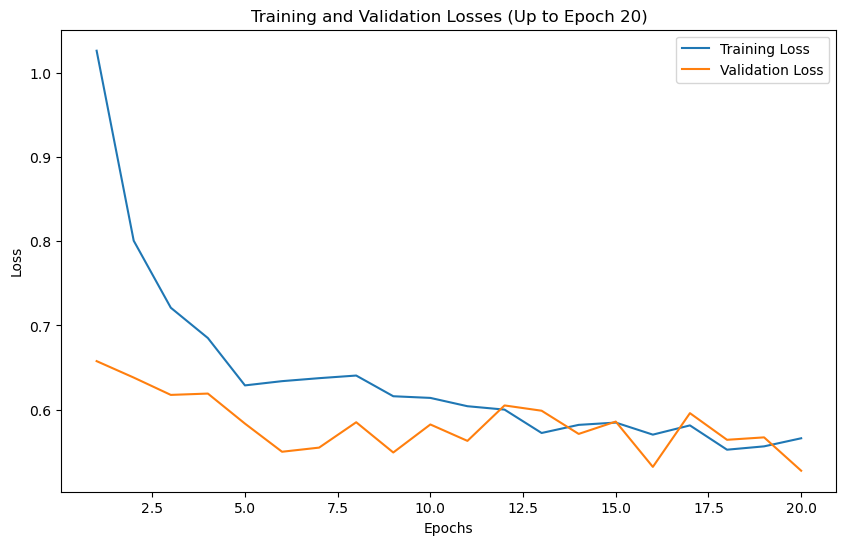

Training: 100%|██████████| 20/20 [39:44<00:00, 119.22s/epoch]

Epoch [20/20] - Training Loss: 0.5659, Validation Accuracy: 0.8040, Validation Loss: 0.5273


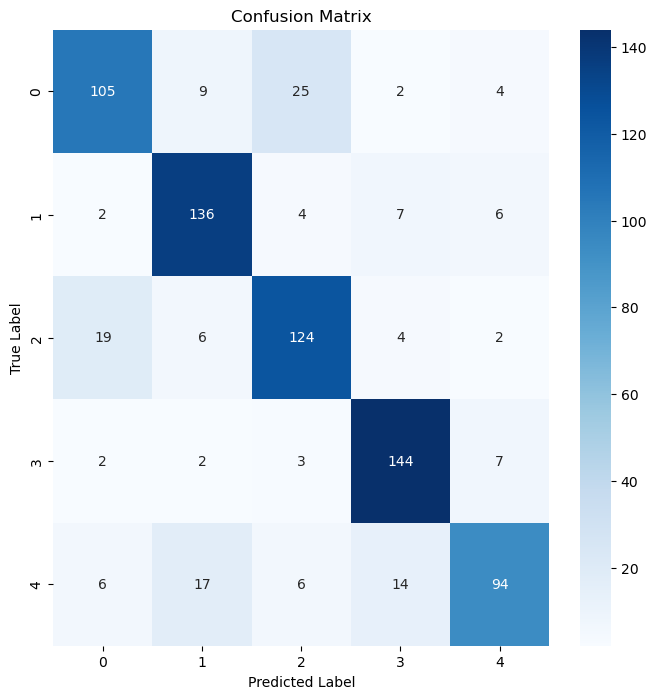

Test Accuracy: 0.8280


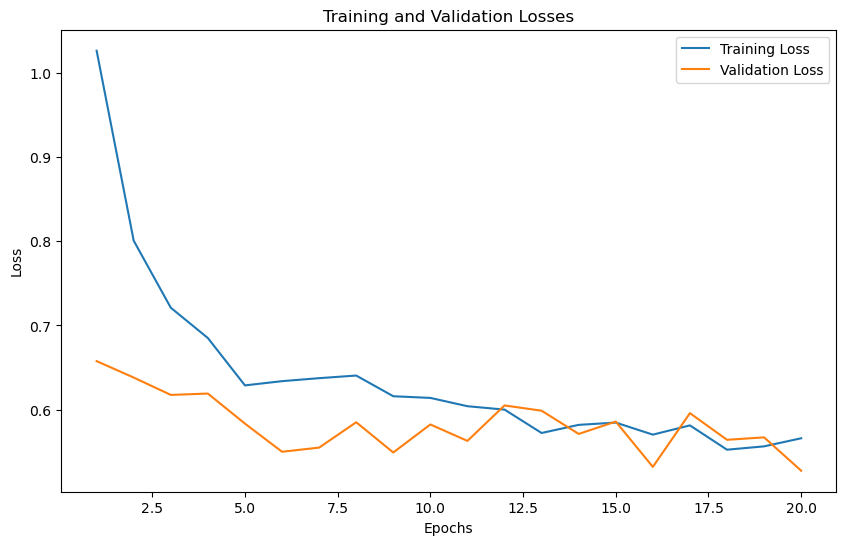

In [22]:
torch.backends.cudnn.enabled = False

print("Device:", device)
if device == torch.device("cpu"):
    print("Training on CPU - not recommended!")
    print("ABORTING")
    exit()

# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 5
learning_rate = 0.001
seed = 42
patience = 10  # Early stopping patience

# Split dataset into 80% training and 20% validation
train_size = int(0.8 * len(subset_train))
val_size = len(subset_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(subset_train, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Initialize model, loss function, and optimizer
model = CustomImageClassifier2(num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_model = None
best_val_accuracy = 0.0
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to keep track of losses and other metrics
training_losses = []
validation_losses = []

# Training loop with Early Stopping
for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    running_loss = 0.0
    num_batches = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    average_training_loss = running_loss / num_batches
    training_losses.append(average_training_loss)

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

    val_accuracy = total_correct / total_samples
    average_val_loss = val_running_loss / len(val_loader)
    validation_losses.append(average_val_loss)

    # Early Stopping Check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # Plotting and printing
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), validation_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses (Up to Epoch {epoch + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_training_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Load the best model for testing
model.load_state_dict(best_model)
model.eval()

# Define the data loader for testing
test_loader = DataLoader(subset_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Testing loop
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels.to(device)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

In [23]:
subset_train2 = train_dataset
subset_test2 = test_dataset

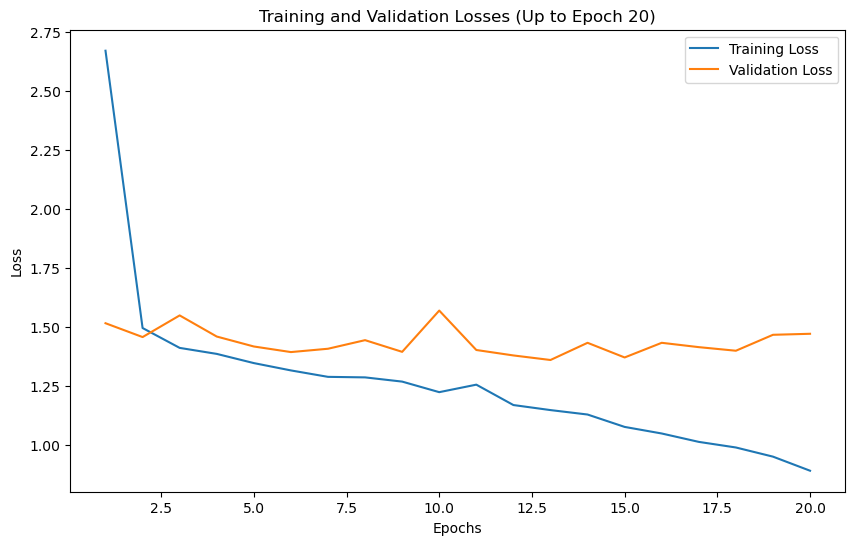

Training: 100%|██████████| 20/20 [39:52<00:00, 119.65s/epoch]

Epoch [20/20] - Training Loss: 0.8896, Validation Accuracy: 0.4317, Validation Loss: 1.4705


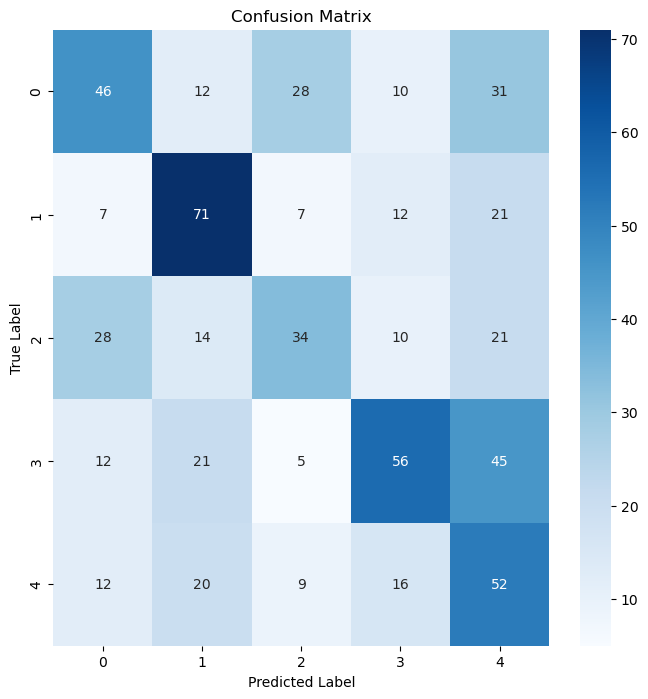

Test Accuracy: 0.0237


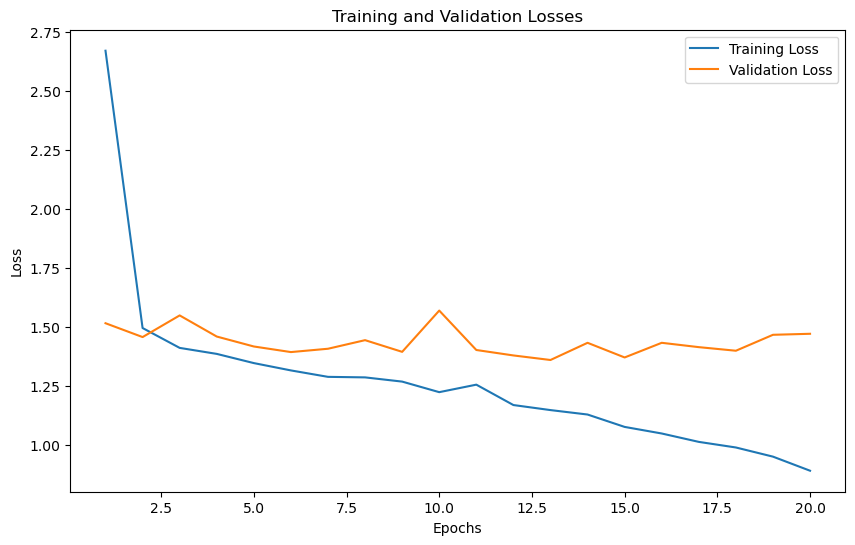

In [26]:
torch.backends.cudnn.enabled = False

print("Device:", device)
if device == torch.device("cpu"):
    print("Training on CPU - not recommended!")
    print("ABORTING")
    exit()

# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 101
learning_rate = 0.001
seed = 42
patience = 10  # Early stopping patience

# Split dataset into 80% training and 20% validation
train_size = int(0.8 * len(subset_train2))
val_size = len(subset_train2) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(subset_train2, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Initialize model, loss function, and optimizer
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_model = None
best_val_accuracy = 0.0
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to keep track of losses and other metrics
training_losses = []
validation_losses = []

# Training loop with Early Stopping
for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    running_loss = 0.0
    num_batches = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    average_training_loss = running_loss / num_batches
    training_losses.append(average_training_loss)

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

    val_accuracy = total_correct / total_samples
    average_val_loss = val_running_loss / len(val_loader)
    validation_losses.append(average_val_loss)

    # Early Stopping Check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # Plotting and printing
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), validation_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses (Up to Epoch {epoch + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_training_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Load the best model for testing
model.load_state_dict(best_model)
model.eval()

# Define the data loader for testing
test_loader = DataLoader(subset_test2, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

# Testing loop
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels.to(device)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the best model
torch.save(best_model, 'bestmodel.pt')